# Train a Random Forest Regressor Model for multiple outputs
### Outputs include number of color source production as well as the number of lands in that deck

In [52]:
import pandas as pd
import numpy as np
import os

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable

import seaborn as sns

import joblib

In [2]:
pd.options.display.max_columns = 20000
pd.set_option('display.width', 1000)

In [6]:
# Load the dataset using pandas
input = pd.read_feather('C:/Users/Peter/Documents/GitHub/MTG-Land-Recommender/data/input.feather')
output = pd.read_feather('C:/Users/Peter/Documents/GitHub/MTG-Land-Recommender/data/output.feather')

In [ ]:
# Combine the input and output data into a single dataframe
data = pd.concat([input, output], axis=1)

# Plot the pairwise scatterplots
sns.pairplot(data)

In [11]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(input, output, test_size=0.2, random_state=42)

Train a multi-output model with no hyperparameter tuning

In [16]:
# Instantiate the RandomForestRegressor
rf_regressor_1 = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model on the training data
rf_regressor_1.fit(X_train, y_train)

# Predict the target values for both the training and testing data
y_train_pred = rf_regressor_1.predict(X_train)
y_test_pred = rf_regressor_1.predict(X_test)

# Calculate the evaluation metrics for the training and testing data
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)

mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

Evaluate the base model across different metrics

In [17]:
# Print the evaluation metrics
print(f"Training MAE: {mae_train:.2f}")
print(f"Testing MAE: {mae_test:.2f}")

print(f"Training MSE: {mse_train:.2f}")
print(f"Testing MSE: {mse_test:.2f}")

print(f"Training R^2: {r2_train:.2f}")
print(f"Testing R^2: {r2_test:.2f}")

Training MAE: 0.43
Testing MAE: 1.14
Training MSE: 0.72
Testing MSE: 4.62
Training R^2: 0.98
Testing R^2: 0.87


Perform Grid-search to find the optimal hyperparameter values

In [18]:
# Define the hyperparameters grid to search
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 5, 10]
}

# Instantiate the RandomForestRegressor
rf_regressor = RandomForestRegressor(random_state=42)

# Instantiate the GridSearchCV with cross-validation
grid_search = GridSearchCV(estimator=rf_regressor, param_grid=param_grid,
                           cv=5, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)

# Fit the GridSearchCV on the training data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_hyperparams = grid_search.best_params_
print(f"Best hyperparameters: {best_hyperparams}")

# Get the best model (fitted with the optimal hyperparameters)
best_model = grid_search.best_estimator_

# Predict the target values for the testing data
y_test_pred = best_model.predict(X_test)

# Calculate the evaluation metrics for the testing data
mae_test = mean_absolute_error(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

# Print the evaluation metrics
print(f"Testing MAE: {mae_test:.2f}")
print(f"Testing MSE: {mse_test:.2f}")
print(f"Testing R^2: {r2_test:.2f}")

Fitting 5 folds for each of 256 candidates, totalling 1280 fits
Best hyperparameters: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Testing MAE: 1.14
Testing MSE: 4.63
Testing R^2: 0.87


Plot the feature importances

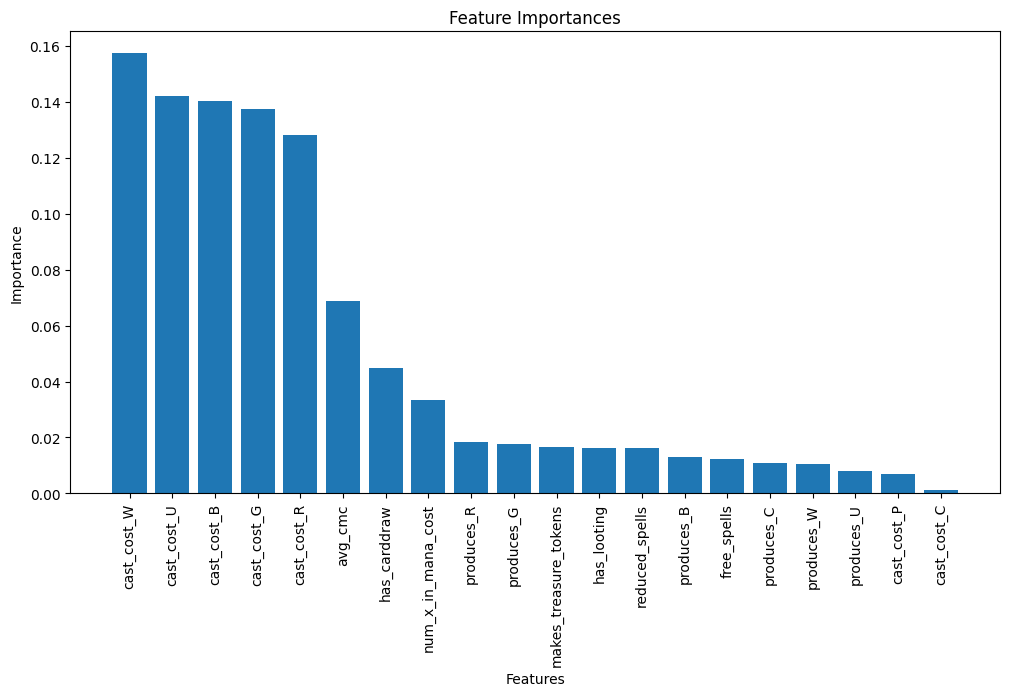

In [21]:
# Get feature importances from the best model
importances = best_model.feature_importances_
feature_importances = list(zip(input.columns, importances))

# Sort the feature importances in descending order
feature_importances.sort(key=lambda x: x[1], reverse=True)

# Separate the feature names and their importances
features, importances = zip(*feature_importances)

# Create a bar plot of feature importances
plt.figure(figsize=(12, 6))
plt.bar(features, importances)
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.show()

In [22]:
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
poly_features = poly.fit_transform(input)

# Get the feature names from the PolynomialFeatures object
feature_names = poly.get_feature_names_out(input_features=input.columns)

# Create a new DataFrame with the polynomial features
input_poly = pd.DataFrame(poly_features, columns=feature_names)

In [ ]:
input_poly

In [24]:
rf_model_poly = RandomForestRegressor(
    max_depth= 30, 
    min_samples_leaf = 1,
    min_samples_split = 2,
    n_estimators = 200)

poly = PolynomialFeatures(degree=2, include_bias=False)

X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

rf_model_poly.fit(X_train_poly, y_train)

y_train_pred = rf_model_poly.predict(X_train_poly)
y_test_pred = rf_model_poly.predict(X_test_poly)

In [28]:
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

In [30]:
print(f'train mean_squared_error:\t{train_mse}')
print(f'test mean_squared_error:\t{test_mse}')
print('\n')
print(f'train mean_absolute_error:\t{train_mae}')
print(f'test mean_absolute_error:\t{test_mae}')

train mean_squared_error:	0.6928343561609426
test mean_squared_error:	4.60313391865546


train mean_absolute_error:	0.4289038351821604
test mean_absolute_error:	1.1471453902394086


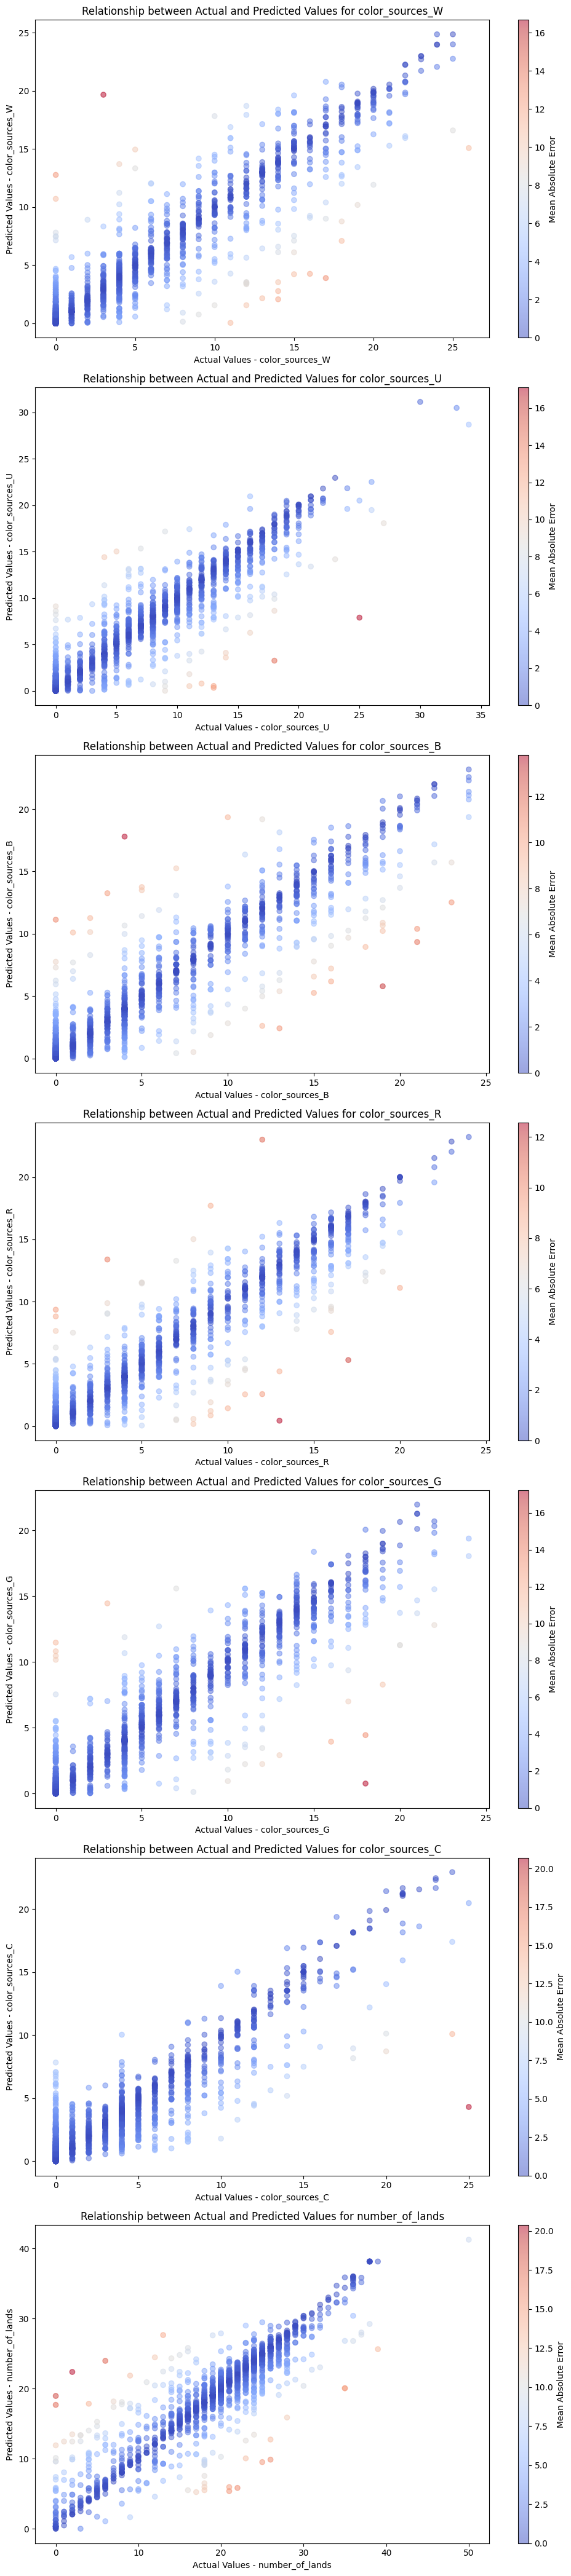

In [50]:
# Calculate the mean absolute errors for each prediction
mae_errors = np.abs(y_test - y_test_pred)

# Plot the scatter plot for each dimension
n_dimensions = mae_errors.shape[1]
fig, axes = plt.subplots(n_dimensions, 1, figsize=(10, 6 * n_dimensions))

# Convert y_test from a numpy array to a pandas DataFrame
y_test = pd.DataFrame(y_test, columns=output.columns)

for i in range(n_dimensions):
    output_feature_name = y_test.columns[i]
    sm = axes[i].scatter(y_test.iloc[:, i], y_test_pred[:, i], c=mae_errors[:, i], cmap='coolwarm', alpha=0.5)
    axes[i].set_xlabel(f'Actual Values - {output_feature_name}')
    axes[i].set_ylabel(f'Predicted Values - {output_feature_name}')
    axes[i].set_title(f'Relationship between Actual and Predicted Values for {output_feature_name}')
    plt.colorbar(sm, ax=axes[i], label='Mean Absolute Error', aspect=30)

plt.tight_layout()
plt.show()